## Minimum Spectral Entropy Demonstration (Phase and Delay)

This notebook demonstrates a method for controlling stochastic delay and phase noise in $H(\nu,t)e^{i(\phi_t+\epsilon_t \nu)}$, where $H(\nu,t)$ is the dynamic frequency response determined by dynamic cyclic spectroscopy, $\phi_t$ and $\epsilon_t$ are the unknown degenerate phase and delay at time $t$.

The method is based on minimizing the spectral entropy in $h(\tau,\omega)$ by varying $\phi_t$ and $\epsilon_t$.

In [1]:
from scipy.fft import rfft, fft, fftshift, ifft, fftn, ifftn
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import psrchive

def freq2time(hf, axis=0):
    return ifft(hf, axis=axis, norm="ortho")

def time2freq(ht, axis=0):
    return fft(ht, axis=axis, norm="ortho")

## Spectral Entropy

Defined as $$U = - \sum_j \sum_k p_{jk} \log_2 p_{jk},$$
where $p_{jk}$ is the fractional power spectral density,

\begin{equation}
p_{jk} = P_{jk} \Sigma_P^{-1},
\end{equation}

$P_{jk} = | h^\prime(\tau_j;\omega_k) |^2$ is the power at a
given delay and Doppler shift, and

\begin{equation}
\Sigma_P =  \sum_j \sum_k P_{jk}
\end{equation}

is the total power summed over all delays and Doppler shifts, which remains constant
as the values of $\phi_t$ and $\epsilon_t$ are varied.

See https://www.overleaf.com/read/mjqhtxmtpmmd#19ec75 for derivation of the partial derivatives $dU/d\phi_t$ and $dU/d\epsilon_t$.

In [2]:
def spectral_entropy_grad(alpha, h_time_freq):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform
    and freq-to-delay inverse Fourier transform of the input h_time_freq after mupltiplying each row/time (except the first) by phi
    and shifting each row/time by delay epsilon

    Args:
    alpha: A 1D array of (Ntime - 1) real-valued phase shifts, in radians,
        and (Ntime - 1) real-valued delays, in radians per cycle, to be applied to each row except the first
    h_time_freq: the dynamic frequency response, a 2D array of Ntime * Nfreq complex-values

    Returns:
    The spectral entropy and its gradient with respect to the phase shifts and delays
    """

    Ntime, Nchan = h_time_freq.shape
    
    phs = np.zeros(Ntime)
    eps = np.zeros(Ntime)

    phs[1:] = alpha[0:Ntime-1]
    eps[1:] = alpha[Ntime-1:]

    nus = np.fft.fftfreq(Nchan)
    h_time_freq_prime = h_time_freq * np.exp(1j * np.outer(eps, nus))
    dh_time_freq_prime_deps_oni = np.multiply(h_time_freq_prime, nus[np.newaxis, :])

    h_time_delay_prime = ifft(h_time_freq_prime, axis=1, norm="ortho")
    dh_time_delay_prime_deps_oni = ifft(dh_time_freq_prime_deps_oni, axis=1, norm="ortho")

    phasors = np.exp(1.j * phs)
    h_time_delay_prime = np.multiply(h_time_delay_prime, phasors[:, np.newaxis])
    dh_time_delay_prime_deps_oni = np.multiply(dh_time_delay_prime_deps_oni, phasors[:, np.newaxis])
    
    h_doppler_delay_prime = fft(h_time_delay_prime, axis=0, norm="ortho")
    
    power_spectrum = np.abs(h_doppler_delay_prime)**2
    
    total_power = np.sum(power_spectrum)
    power_spectrum /= total_power
    log_power_spectrum = np.log2(power_spectrum + 1e-16)
    entropy = -np.sum(power_spectrum * log_power_spectrum)

    weighted_ifft = fft((1.+log_power_spectrum)*np.conj(h_doppler_delay_prime), axis=0, norm="ortho")

    # partial derivatives with respect to phi_l
    gradient_phs = 2.0/total_power * np.sum( np.imag( weighted_ifft*h_time_delay_prime ), axis=1)
    grad_phs_power = np.sum(gradient_phs**2)

    # partial derivatives with respect to epsilon_l
    gradient_eps = 2.0/total_power * np.sum( np.imag( weighted_ifft*dh_time_delay_prime_deps_oni ), axis=1)    
    grad_eps_power = np.sum(gradient_eps**2)

    rms = np.sqrt(np.sum(phs**2) / (Ntime-1))
    print (f"rms={rms:.4g} rad; S={entropy} grad power phs={grad_phs_power:.4} eps={grad_eps_power:.4}")

    return entropy, np.concatenate((gradient_phs[1:],gradient_eps[1:]))

def spectral_entropy(h_time_freq):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform 
    of the input h_time_delay

    Args:
    h_time_freq: the dynamic frequency response, a 2D array of Ntime * Nfreq complex-values

    Returns:
    The spectral entropy
    """
    nsub, nchan = h_time_freq.shape
    alpha = np.zeros(2*(nsub-1))
    entropy, grad = spectral_entropy_grad(alpha,h_time_freq)
    return entropy

## Minimize the spectral entropy using BFGS

In [3]:
from scipy.optimize import minimize

def circular(x):
    x[:] = np.fmod(x, 2.0*np.pi)

def minimize_spectral_entropy(h_time_freq, guess_phi = None, guess_eps = None):

    Ntime, Nchan = h_time_freq.shape
    initial_guess = np.zeros(2*(Ntime - 1))

    if guess_phi is not None:
        print("Setting first guess for phi")
        initial_guess[0:Ntime-1] = guess_phi

    if guess_eps is not None:
        print("Setting first guess for epsilon")
        initial_guess[Ntime-1:] = guess_eps
        
    options = {"maxiter": 1000, "disp": True}

    result = minimize(
        spectral_entropy_grad,
        initial_guess,
        args=(h_time_freq,),
        method="BFGS",
        jac=True,
        callback=circular,
        options=options,
    )

    alpha = result.x
    phs = np.zeros(Ntime)
    eps = np.zeros(Ntime)

    phs[1:] = alpha[0:Ntime-1]
    eps[1:] = alpha[Ntime-1:]

    nus = np.fft.fftfreq(Nchan)
    h_time_freq_prime = h_time_freq * np.exp(1j * np.outer(eps, nus))

    phasors = np.exp(1.j * phs)
    h_time_freq[:,:] = np.multiply(h_time_freq_prime, phasors[:, np.newaxis])

### Difference between two spectra

Details of chi-squared function


In [172]:

def spectral_distance(alpha, z, w):
    """
    Calculates the magnitude of the difference between the two spectra in the two halve of two_spectra
    after mupltiplying the second one by an amplitude, phase, and phase gradient

    Args:
    alpha: A 1D array of 3 values: amplitude, phase, and slope
    two_spectra: the complex-valued spectra to be aligned

    Returns:
    The distance and its gradient with respect to the 3 parameters in alpha
    """

    Nchan = z.size
    phase = alpha[0]
    slope = alpha[1]
    amplitude = 1
    print(f"{amplitude=} {phase=} {slope=}")

    nus = np.fft.fftfreq(Nchan)
    wprime = amplitude * np.exp(1j * phase) * w * np.exp(1j * slope * nus)
    delta = z - wprime

    diff = np.sum(np.abs(delta)**2)

    del_amplitude = wprime / amplitude
    del_phase = 1j * wprime
    del_slope = 1j * nus * wprime

    ddiff_damp = -2 * np.sum ( np.real( np.conj(delta) * del_amplitude ) )
    ddiff_dphs = -2 * np.sum ( np.real( np.conj(delta) * del_phase ) )
    ddiff_dslo = -2 * np.sum ( np.real( np.conj(delta) * del_slope ) )

    print(f"{diff=} del_a={ddiff_damp} del_phi={ddiff_dphs} del_eps={ddiff_dslo}")
    return diff, [ddiff_dphs, ddiff_dslo]

def minimize_difference(z, w):

    Nchan = z.size
    initial_guess = np.zeros(2)

    ccf = fft( np.conj(w) * z )
    ccf_power = np.abs(ccf)**2
    imax = np.argmax(ccf_power)
    ph_max = np.angle(ccf[imax])

    print(f"{imax=} {ph_max=} {Nchan=}")
    
    initial_guess[0] = ph_max

    if imax < Nchan // 2:
        slope = imax
    else:
        slope = imax - Nchan

    initial_guess[1] = slope * 2.0 * np.pi

    options = {"maxiter": 1000, "disp": True, "gtol": 1e-12}
    
    result = minimize(
        spectral_distance,
        initial_guess,
        args=(z,w),
        method="BFGS",
        jac=True,
        # callback=circular,
        options=options,
    )

    alpha = result.x

    phase = alpha[0]
    slope = alpha[1]
    amplitude = 1
    
    nus = np.fft.fftfreq(Nchan)
    w[:] = amplitude * np.exp(1j * phase) * w * np.exp(1j * slope * nus)

## Simulated scattering screen

Load a simulated dynamic response, $H(\nu,t)$ that was generated using 

    dyn_resp_sim input.ar -w1
    
This generates a single scintillation arc with a Gaussian width of one pixel.  The following code also plots $h(\tau,\omega)$ and reports the original entropy.

**Note the original spectral entropy of 7.656.**

In [181]:
filename = "test/dyn_resp_sim.fits"
ar = psrchive.Archive_load(filename)
ext = ar.get_dynamic_response()
data = ext.get_data()
nchan = ext.get_nchan()
ntime = ext.get_ntime()
h_time_freq = np.reshape(data, (ntime, nchan))

start_time = ext.get_minimum_epoch ()
end_time = ext.get_maximum_epoch ()
dT = (end_time-start_time).in_seconds() / ntime
if dT == 0:
    dT = 1

print(f"start_time={start_time.printdays(13)} end_time={end_time.printdays(13)}")

bw = ext.get_bandwidth()
cfreq = ext.get_centre_frequency()

print(f"delta-T={dT} centre frequency={cfreq} bandwidth={bw}")
print(f"\nInitial Spectral Entropy: {spectral_entropy(h_time_freq)}\n")


start_time=0.0000000000000 end_time=0.0000000000000
delta-T=1 centre frequency=428.0 bandwidth=4.0
rms=0 rad; S=7.728397491178674 grad power phs=0.000641 eps=5.487e-05

Initial Spectral Entropy: 7.728397491178674



rms=0 rad; S=7.728397491178674 grad power phs=0.000641 eps=5.487e-05
Spectral Entropy: 7.728397491178674


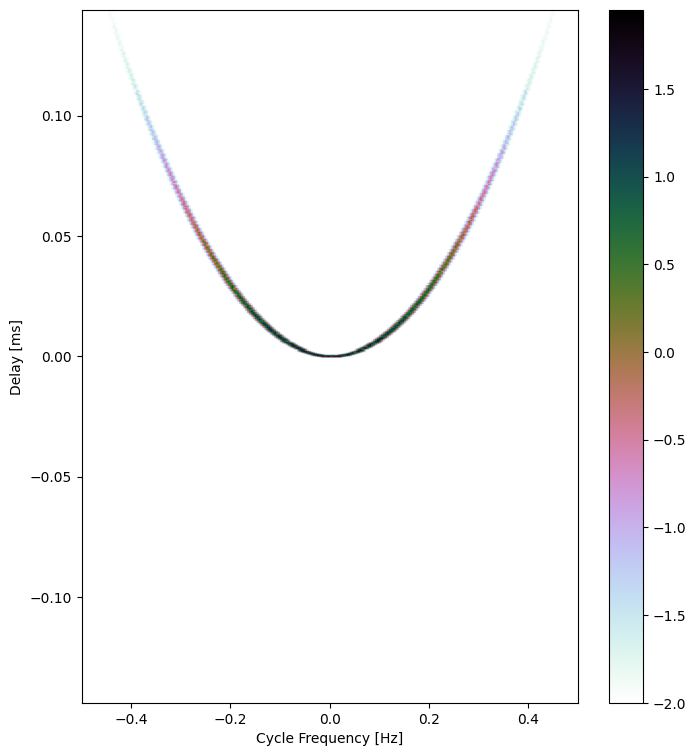

In [182]:
def plot_Doppler_vs_delay (h_time_freq, dT, cfreq, bw):

    print(f"Spectral Entropy: {spectral_entropy(h_time_freq)}")

    h_time_delay = freq2time(h_time_freq, axis=1)
    h_doppler_delay = time2freq(h_time_delay, axis=0)

    ntime, ntap = h_time_delay.shape

    delta_delay_mus = np.abs(1.0 / bw)
    max_delay_ms = delta_delay_mus * ntap * 0.5e-3
    max_Doppler_Hz = .5 / dT
    
    extent=[-max_Doppler_Hz, max_Doppler_Hz, -max_delay_ms, max_delay_ms]
    
    plotthis = np.log10(np.abs(fftshift(h_doppler_delay)) + 1e-2)
    plotmed = np.median(plotthis)
    fig, ax = plt.subplots(figsize=(8, 9))

    ax.set_xlabel("Cycle Frequency [Hz]")
    ax.set_ylabel("Delay [ms]")
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=plotmed, extent=extent)

    fig.colorbar(img)
    
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

## Scramble the phases

Multiply each row of the dynamic frequency response by a random phase.

In [183]:
max_phase = np.pi*4
phases = np.random.uniform(-max_phase,max_phase,ntime)
phases[0] = 0
phasors = np.exp( 1j * phases)
h_time_freq = np.multiply(h_time_freq, phasors[:, np.newaxis])

## Scramble the delays

Multiply each row of the dynamic frequency response by a phase slope for a random delay.

In [184]:
eps = np.random.uniform(-max_phase,max_phase,ntime)
eps[0] = 0
nus = np.fft.fftfreq(nchan)
h_time_freq = h_time_freq * np.exp(1j * np.outer(eps, nus))

## Unaligned Wavefield

A Fourier transform along the delay axis yields $H(\nu,t)$, which is then passed to the plot function, which computes and plots the 2D FFT, $h(\tau,\omega)$.  This is expected to look like white Doppler noise because of the large time shifts $\epsilon_t$ that are clearly visible in the above plot.

rms=0 rad; S=13.58148372907223 grad power phs=0.0002949 eps=3.988e-05
Spectral Entropy: 13.58148372907223


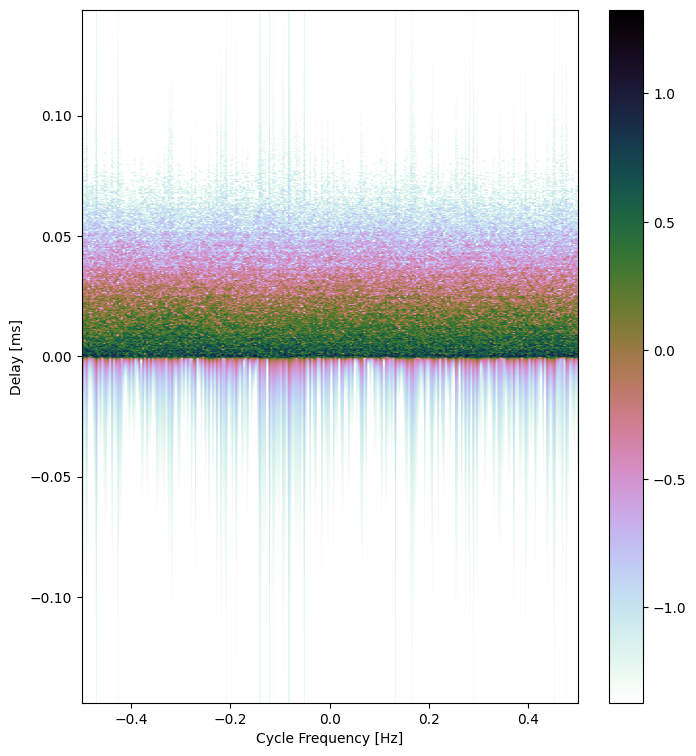

In [185]:
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

## Coarse alignment using the cross-correlation function.

Each impulse response in $h(\tau,t)$ is aligned to its neighbour and multiplied by a phase term, based on the cross-correlation between them.

In [186]:
def align_to_neighbour(subset):
    nt, ntau = subset.shape
    x = subset[0]
    for idx in range(1,nt):
        y = subset[idx]
        minimize_difference(x,y)
        x = y
        subset[idx,:] = y

In [187]:
coarse_h_time_freq = np.copy(h_time_freq)
align_to_neighbour(coarse_h_time_freq)

imax=0 ph_max=-1.9835139564255448 Nchan=1152
amplitude=1 phase=-1.9835139564255448 slope=0.0
diff=365.5868661825449 del_a=341.06323872848316 del_phi=-2.5579538487363607e-13 del_eps=82.54927489078216
amplitude=1 phase=-1.9835139564255417 slope=-1.01
diff=368.5264523549663 del_a=344.00282490090444 del_phi=0.3027646663962571 del_eps=-88.57314821346053
amplitude=1 phase=-1.9835139564255433 slope=-0.4879607399491207
diff=345.3595516252976 del_a=320.835924171236 del_phi=-0.2935255827681713 del_eps=0.04562619466293372
amplitude=1 phase=-1.6898260480440255 slope=-0.48927545399974265
diff=435.9930772355335 del_a=411.4694497814719 del_phi=613.0599063550497 del_eps=-0.19269003887501412
amplitude=1 phase=-1.983376301829083 slope=-0.4879613561693563
diff=345.35953126582166 del_a=320.83590381176 del_phi=-0.0018716804861842462 del_eps=0.04551138240662311
amplitude=1 phase=-1.9833754282533438 slope=-0.4882305668309916
diff=345.3595251908144 del_a=320.8358977367526 del_phi=-1.60070374732868e-06 del_eps

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

amplitude=1 phase=-1.0436457136047426 slope=-9.525212256729699
diff=362.94835018945196 del_a=413.4701160815945 del_phi=-35.01351219495262 del_eps=-16.95222985873457
amplitude=1 phase=-1.030356427183041 slope=-9.439713014502756
diff=362.0499081213201 del_a=412.57167401346294 del_phi=3.8109004698688764 del_eps=0.7853867825642697
amplitude=1 phase=-1.032092618783621 slope=-9.442553728928253
diff=362.0456756431209 del_a=412.5674415352635 del_phi=-0.29571082953877337 del_eps=0.046054251888547615
amplitude=1 phase=-1.0319272552802148 slope=-9.4429547662674
diff=362.04564555557766 del_a=412.5674114477205 del_phi=0.017524434189994054 del_eps=-0.01071287356376649
amplitude=1 phase=-1.0319385662896297 slope=-9.442890448106223
diff=362.0456451148225 del_a=412.56741100696513 del_phi=0.00037744722769161854 del_eps=0.00015563754181702194
amplitude=1 phase=-1.0319387051247177 slope=-9.442891195367253
diff=362.0456451147397 del_a=412.5674110068825 del_phi=-1.126785029725852e-05 del_eps=-1.981523547467

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

amplitude=1 phase=-0.09855758891250668 slope=-13.216561894441549
diff=342.3048939893818 del_a=327.7058035542952 del_phi=0.00033238745528052505 del_eps=-1.713390779345403e-05
amplitude=1 phase=-0.098557762407088 slope=-13.216561748108687
diff=342.3048939893518 del_a=327.70580355426506 del_phi=-9.36199981538266e-07 del_eps=-9.671008971423589e-08
amplitude=1 phase=-0.09855776192531723 slope=-13.216561747386042
diff=342.30489398935185 del_a=327.705803554265 del_phi=1.2349943290246301e-10 del_eps=1.4646417412222945e-10
amplitude=1 phase=-0.09855776240635551 slope=-13.216561748107587
diff=342.3048939893518 del_a=327.705803554265 del_phi=-9.347763842981749e-07 del_eps=-9.656277644154443e-08
amplitude=1 phase=-0.09855776208887025 slope=-13.216561747631367
diff=342.3048939893518 del_a=327.705803554265 del_phi=-3.17742465227866e-07 del_eps=-3.273469184605915e-08
         Current function value: 342.304894
         Iterations: 8
         Function evaluations: 15
         Gradient evaluations: 15


/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=314.1146981211966 del_a=323.72794438930214 del_phi=-0.40942008240576655 del_eps=-0.07010144555332687
amplitude=1 phase=0.42561769595285814 slope=-5.595534228096004
diff=314.114630774818 del_a=323.7278770429234 del_phi=0.0017934365663592189 del_eps=0.00027078720539641665
amplitude=1 phase=0.4256167570864563 slope=-5.595536815370274
diff=314.1146307736258 del_a=323.7278770417313 del_phi=1.110019667294182e-07 del_eps=-2.6971926914143296e-08
amplitude=1 phase=0.42561675702927565 slope=-5.595536815118768
diff=314.1146307736258 del_a=323.7278770417313 del_phi=1.1729639481927734e-10 del_eps=-4.2570391656227e-11
         Current function value: 314.114631
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12
imax=0 ph_max=-1.2680189781456066 Nchan=1152
amplitude=1 phase=-1.2680189781456066 slope=0.0
diff=524.2400275350656 del_a=492.15135233076376 del_phi=2.2737367544323206e-13 del_eps=-179.3565501403115
amplitude=1 phase=-1.268018978145608 slope=1.0100

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=316.75337771816356 del_a=298.85447957056306 del_phi=2.781478084301625e-06 del_eps=-1.6432279426048524e-07
amplitude=1 phase=-0.4254136107629379 slope=-4.9071268430573465
diff=316.7533777181636 del_a=298.85447957056306 del_phi=2.781477508762009e-06 del_eps=-1.6432277227806935e-07
amplitude=1 phase=-0.4254136107629376 slope=-4.9071268430573465
diff=316.75337771816356 del_a=298.85447957056306 del_phi=2.781478084301625e-06 del_eps=-1.6432279426048524e-07
amplitude=1 phase=-0.42541361076293777 slope=-4.9071268430573465
diff=316.7533777181636 del_a=298.8544795705633 del_phi=2.781477796531817e-06 del_eps=-1.6432278182598736e-07
amplitude=1 phase=-0.4254136107629376 slope=-4.9071268430573465
diff=316.75337771816356 del_a=298.85447957056306 del_phi=2.781478084301625e-06 del_eps=-1.6432279426048524e-07
amplitude=1 phase=-0.42541361076293766 slope=-4.9071268430573465
diff=316.75337771816356 del_a=298.85447957056317 del_phi=2.781477988378356e-06 del_eps=-1.6432279115186077e-07
amplitude=1 pha

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

In [188]:
align_to_neighbour(coarse_h_time_freq)

imax=0 ph_max=8.436437515115841e-17 Nchan=1152
amplitude=1 phase=8.436437515115841e-17 slope=0.0
diff=345.3595251903786 del_a=320.8358977363168 del_phi=-2.7533531010703882e-14 del_eps=-4.440892098500626e-15
Optimization terminated successfully.
         Current function value: 345.359525
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
imax=0 ph_max=7.8353848422235e-17 Nchan=1152
amplitude=1 phase=7.8353848422235e-17 slope=0.0
diff=348.1210779760338 del_a=345.2314938224848 del_phi=-1.5987211554602254e-14 del_eps=1.9539925233402755e-14
Optimization terminated successfully.
         Current function value: 348.121078
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
imax=0 ph_max=1.1841937611153282e-16 Nchan=1152
amplitude=1 phase=1.1841937611153282e-16 slope=0.0
diff=368.9955616110422 del_a=419.276405767397 del_phi=-1.7763568394002505e-15 del_eps=8.881784197001252e-15
Optimization terminated successfully.
   

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=365.8330317038624 del_a=611.4348397850882 del_phi=1.2758313161498336e-07 del_eps=1.185330944508678e-09
         Current function value: 365.833032
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
imax=0 ph_max=6.674737505293785e-10 Nchan=1152
amplitude=1 phase=6.674737505293785e-10 slope=0.0
diff=290.10193825028597 del_a=386.2187500312465 del_phi=-6.217248937900877e-15 del_eps=-9.012475654657237e-08
amplitude=1 phase=6.674799677783164e-10 slope=9.012475654657237e-08
diff=290.10193825028693 del_a=386.2187500312474 del_phi=2.318145026158902e-05 del_eps=2.050091963212708e-05
amplitude=1 phase=6.674737741916626e-10 slope=3.430066280388039e-10
diff=290.10193825028597 del_a=386.2187500312465 del_phi=8.822649633088986e-08 del_eps=-1.1757113504984318e-08
         Current function value: 290.101938
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
imax=0 ph_max=6.904252791128311e-10 Nchan=1152
amplitude=1 phase=

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=375.4883582103861 del_a=396.6443242745487 del_phi=-1.31087674049013e-09 del_eps=2.6645352591003757e-15
amplitude=1 phase=-4.0288521373275204e-10 slope=-2.2656471977691283e-10
diff=375.488358210386 del_a=396.6443242745487 del_phi=-2.6221513849122857e-09 del_eps=1.7763568394002505e-15
amplitude=1 phase=-4.0288521372698416e-10 slope=-2.2656471977775407e-10
diff=375.488358210386 del_a=396.6443242745487 del_phi=-2.6221513849122857e-09 del_eps=1.7763568394002505e-15
amplitude=1 phase=-4.0245213647622973e-10 slope=-2.2662788265272828e-10
diff=375.4883582103861 del_a=396.6443242745487 del_phi=-1.9665158390580473e-09 del_eps=8.881784197001252e-16
amplitude=1 phase=-4.028852137255422e-10 slope=-2.2656471977796438e-10
diff=375.488358210386 del_a=396.6443242745487 del_phi=-2.6221513849122857e-09 del_eps=1.7763568394002505e-15
amplitude=1 phase=-4.028852137241002e-10 slope=-2.2656471977817467e-10
diff=375.488358210386 del_a=396.6443242745487 del_phi=-2.6221513849122857e-09 del_eps=1.7763568394

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=342.65053719190416 del_a=449.180847174184 del_phi=-7.105427357601002e-15 del_eps=-1.0413486073446165e-08
amplitude=1 phase=2.9196989372649467e-09 slope=1.0413486073446165e-08
diff=342.65053719190416 del_a=449.18084717418407 del_phi=-8.465216900788164e-07 del_eps=1.2730711480557488e-06
amplitude=1 phase=2.9196918894871317e-09 slope=8.448931769024934e-11
diff=342.65053719190416 del_a=449.180847174184 del_phi=-6.868205559840135e-09 del_eps=6.217248937900877e-15
         Current function value: 342.650537
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
imax=0 ph_max=2.9157867338221084e-09 Nchan=1152
amplitude=1 phase=2.9157867338221084e-09 slope=0.0
diff=313.9004941080573 del_a=377.2173984975391 del_phi=-1.4210854715202004e-14 del_eps=-1.3222667405443644e-08
amplitude=1 phase=2.9158009446768236e-09 slope=1.3222667405443644e-08
diff=313.90049410805733 del_a=377.2173984975392 del_phi=-1.5201990599678084e-06 del_eps=2.009653269574585e-06
amplitude

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

## Coarsely-aligned Wavefield

This still looks like white Doppler noise because of the remaining fractional time shifts $\epsilon_t$.

rms=0 rad; S=9.286024832013837 grad power phs=0.003276 eps=0.001285
Spectral Entropy: 9.286024832013837


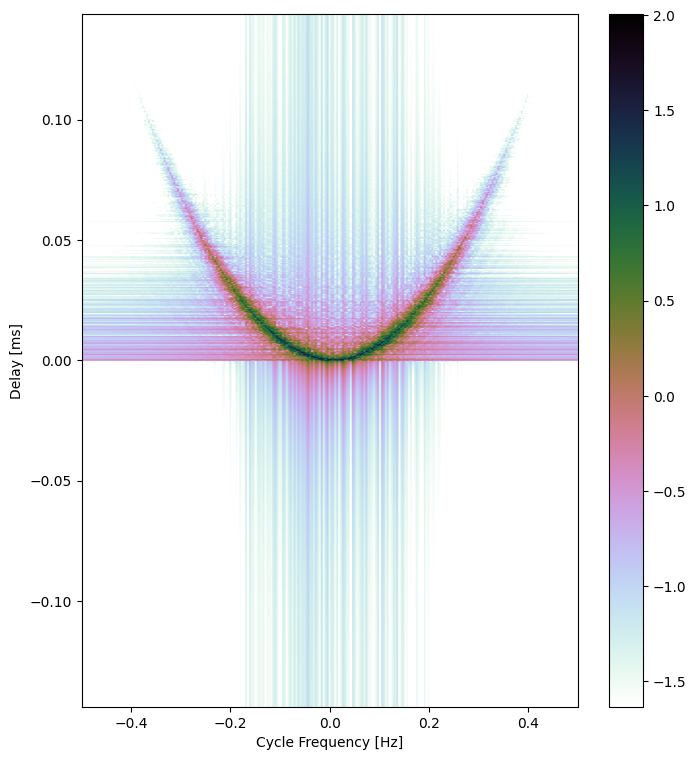

In [189]:
plot_Doppler_vs_delay(coarse_h_time_freq, dT, cfreq, bw)

## Perform fine alignment by minimizing the spectral entropy

In [190]:
first_guess_phi = -phases[1:]
first_guess_eps = -eps[1:]
# minimize_spectral_entropy(h_time_freq, first_guess_phi, first_guess_eps)
minimize_spectral_entropy(coarse_h_time_freq)

rms=0 rad; S=9.286024832013837 grad power phs=0.003276 eps=0.001285
rms=0.003532 rad; S=9.281615953818948 grad power phs=0.003184 eps=0.001293
rms=0.01766 rad; S=9.264450731385804 grad power phs=0.002841 eps=0.001321
rms=0.07418 rad; S=9.203999952817082 grad power phs=0.001972 eps=0.001427
rms=0.2464 rad; S=9.112657048412435 grad power phs=0.005313 eps=0.001549
rms=0.2611 rad; S=9.105853990901638 grad power phs=0.005537 eps=0.001545
rms=0.2771 rad; S=9.092836476397125 grad power phs=0.0053 eps=0.001543
rms=0.2998 rad; S=9.068676474561569 grad power phs=0.004449 eps=0.001538
rms=0.338 rad; S=9.02867289072534 grad power phs=0.003052 eps=0.001522
rms=0.397 rad; S=8.996107585583628 grad power phs=0.004439 eps=0.001467
rms=0.3908 rad; S=8.990490886913403 grad power phs=0.004339 eps=0.001483
rms=0.3812 rad; S=8.97998156296908 grad power phs=0.004043 eps=0.001504
rms=0.3691 rad; S=8.960975839483455 grad power phs=0.003684 eps=0.001527
rms=0.357 rad; S=8.929456081151518 grad power phs=0.003806

## Finely-aligned Wavefield

After fine alignment, an arc appears!  It's at a funny delay and Doppler shift, but it's a start!  The offeset in cycle frequency $\Delta\omega$ could be fixed by a applying a phase gradient along the time axis; i.e. $h^\prime(\tau,t)= h(\tau,t)\exp(i2\pi t\Delta\omega)$

rms=0 rad; S=7.819026554579339 grad power phs=1.138e-09 eps=0.0001746
Spectral Entropy: 7.819026554579339


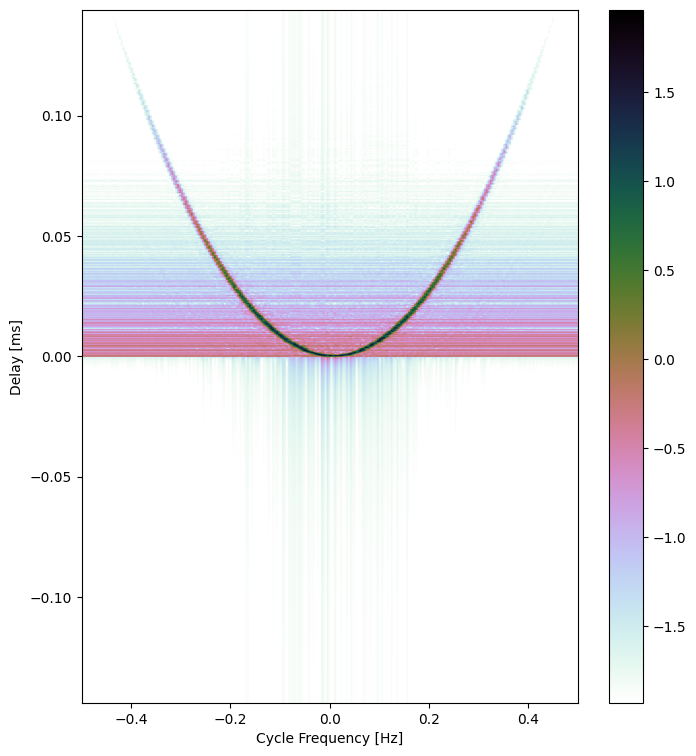

In [191]:
plot_Doppler_vs_delay(coarse_h_time_freq, dT, cfreq, bw)

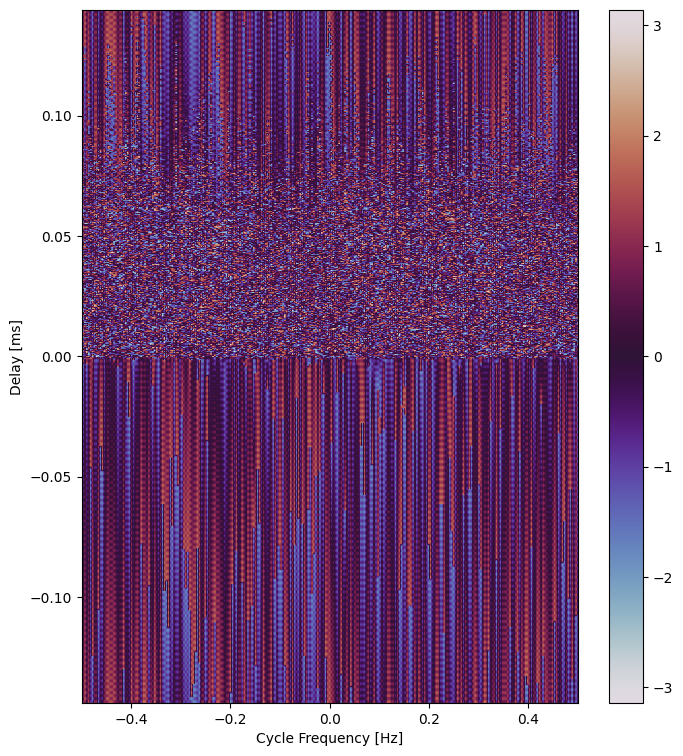

In [192]:
import matplotlib.colors as mcolors

# Define the color cycle
colors = ["blue", "red", "blue"]

# Create the colormap
cmap_name = "cyclic_colormap"
cyclic_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

def plot_Doppler_vs_delay_phase (h_time_freq, dT, cfreq, bw):

    h_time_delay = freq2time(h_time_freq, axis=1)
    h_doppler_delay = time2freq(h_time_delay, axis=0)

    ntime, ntap = h_time_delay.shape

    delta_delay_mus = np.abs(1.0 / bw)
    max_delay_ms = delta_delay_mus * ntap * 0.5e-3
    max_Doppler_Hz = .5 / dT
    
    extent=[-max_Doppler_Hz, max_Doppler_Hz, -max_delay_ms, max_delay_ms]
    
    plotthis = np.angle(fftshift(h_doppler_delay))
    fig, ax = plt.subplots(figsize=(8, 9))

    ax.set_xlabel("Cycle Frequency [Hz]")
    ax.set_ylabel("Delay [ms]")
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap='twilight', extent=extent)

    fig.colorbar(img)

plot_Doppler_vs_delay_phase(h_time_freq, dT, cfreq, bw)